In [1]:
import numpy as np
import pandas as pd
from small_text import LeastConfidence, PoolBasedActiveLearner, random_initialization_balanced, TextDataset
from small_text.integrations.transformers.classifiers.setfit import SetFitModelArguments
from small_text.integrations.transformers.classifiers.factories import SetFitClassificationFactory
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from synergy_dataset import Dataset, iter_datasets

from imblearn.over_sampling import SMOTEN

import torch

from transformers import AutoModel

from sklearn.model_selection import train_test_split
import gc

/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-08 08:46:29.058280: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-08 08:46:29.269703: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-08 08:46:30.154562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/pyalex/api.py:493: DeprecationWarning: Concep

In [2]:
dataset = Dataset('Radjenovic_2013')
dataset = dataset.to_frame()
dataset = dataset.dropna()

X = np.array(dataset['abstract'])
y = np.array(dataset['label_included'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
sampler = SMOTEN(random_state=42)
X_train_os, y_train_os = sampler.fit_resample(X_train.reshape(-1, 1), y_train)

In [4]:
num_classes = 2
target_labels = [0, 1]
train = TextDataset.from_arrays(X_train_os, y_train_os, target_labels=target_labels)
# train = TextDataset.from_arrays(X_train, y_train, target_labels=target_labels)
test = TextDataset.from_arrays(X_test, y_test, target_labels=target_labels)

/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/utils/annotations.py:67: ExperimentalWarning: The function from_arrays is experimental and maybe subject to change soon.
  warnings.warn(f'The {subject} {func_or_class.__name__} is experimental '
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)


In [5]:
sentence_transformer_model_name = 'meta-llama/Meta-Llama-3-8B'
# model = AutoModel.from_pretrained('./Meta-Llama-3-8B')
setfit_model_args = SetFitModelArguments(sentence_transformer_model_name)
clf_factory = SetFitClassificationFactory(setfit_model_args, num_classes, classification_kwargs={'device': 'cuda', 'max_seq_len': 256, 'mini_batch_size': 32})

In [6]:
query_strategy = LeastConfidence()
setfit_train_kwargs = {'show_progress_bar': False}
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, train, fit_kwargs={'setfit_train_kwargs': setfit_train_kwargs})

In [7]:
indices_initial = random_initialization_balanced(train.y, n_samples=2)
active_learner.initialize_data(indices_initial, train.y[indices_initial])

No sentence-transformers model found with name meta-llama/Meta-Llama-3-8B. Creating a new one with MEAN pooling.
Loading checkpoint shards:  25%|██▌       | 1/4 [00:03<00:11,  3.82s/it]

: 

In [ ]:
num_queries = 10
results_setfit = []

for i in range(num_queries):
    indices_queried = active_learner.query(num_samples=2)
    y = train.y[indices_queried]
    active_learner.update(y)
    gc.collect()
    torch.cuda.empty_cache()

    y_pred_train = active_learner.classifier.predict(train)
    y_pred_test = active_learner.classifier.predict(test)

    print(f'\nIteration {i+1}')
    print('Train accuracy: {:.2f}'.format(accuracy_score(train.y, y_pred_train)))
    print('Train precision: {:.2f}'.format(precision_score(train.y, y_pred_train, zero_division=0)))
    print('Train recall: {:.2f}'.format(recall_score(train.y, y_pred_train, zero_division=0)))
    print('Train F1 score: {:.2f}'.format(f1_score(train.y, y_pred_train)))
    print('\n')
    print('Test accuracy: {:.2f}'.format(accuracy_score(test.y, y_pred_test)))
    print('Test precision: {:.2f}'.format(precision_score(test.y, y_pred_test, zero_division=0)))
    print('Test recall: {:.2f}'.format(recall_score(test.y, y_pred_test, zero_division=0)))
    print('Test F1 score: {:.2f}'.format(f1_score(test.y, y_pred_test)))
    
    results_setfit.append([accuracy_score(train.y, y_pred_train), 
                           accuracy_score(test.y, y_pred_test), 
                           f1_score(train.y, y_pred_train), 
                           f1_score(test.y, y_pred_test), 
                           recall_score(train.y, y_pred_train), 
                           recall_score(test.y, y_pred_test)])

/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.1852, 'learning_rate': 2e-05, 'epoch': 0.1}



100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


{'train_runtime': 6.8501, 'train_samples_per_second': 23.357, 'train_steps_per_second': 1.46, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 1
Train accuracy: 0.91
Train precision: 0.38
Train recall: 0.24
Train F1 score: 0.30


Test accuracy: 0.90
Test precision: 0.34
Test recall: 0.20
Test F1 score: 0.25


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.1591, 'learning_rate': 1e-05, 'epoch': 0.07}



100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


{'train_runtime': 10.3312, 'train_samples_per_second': 23.231, 'train_steps_per_second': 1.452, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 2
Train accuracy: 0.91
Train precision: 0.33
Train recall: 0.14
Train F1 score: 0.20


Test accuracy: 0.91
Test precision: 0.37
Test recall: 0.14
Test F1 score: 0.20


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.1978, 'learning_rate': 1e-05, 'epoch': 0.05}



100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


{'train_runtime': 13.811, 'train_samples_per_second': 23.17, 'train_steps_per_second': 1.448, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 3
Train accuracy: 0.92
Train precision: 0.41
Train recall: 0.02
Train F1 score: 0.04


Test accuracy: 0.91
Test precision: 0.14
Test recall: 0.01
Test F1 score: 0.01


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.2366, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.04}



100%|██████████| 25/25 [00:16<00:00,  1.52it/s]


{'train_runtime': 16.465, 'train_samples_per_second': 24.294, 'train_steps_per_second': 1.518, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 4
Train accuracy: 0.92
Train precision: 0.55
Train recall: 0.04
Train F1 score: 0.07


Test accuracy: 0.92
Test precision: 0.47
Test recall: 0.06
Test F1 score: 0.10


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.1925, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.03}



100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


{'train_runtime': 20.6059, 'train_samples_per_second': 23.294, 'train_steps_per_second': 1.456, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 5
Train accuracy: 0.92
Train precision: 0.59
Train recall: 0.21
Train F1 score: 0.31


Test accuracy: 0.92
Test precision: 0.48
Test recall: 0.17
Test F1 score: 0.25


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.3216, 'learning_rate': 5e-06, 'epoch': 0.03}



100%|██████████| 35/35 [00:24<00:00,  1.44it/s]


{'train_runtime': 24.3655, 'train_samples_per_second': 22.983, 'train_steps_per_second': 1.436, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 6
Train accuracy: 0.92
Train precision: 0.56
Train recall: 0.10
Train F1 score: 0.18


Test accuracy: 0.92
Test precision: 0.56
Test recall: 0.09
Test F1 score: 0.15


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.2558, 'learning_rate': 5e-06, 'epoch': 0.03}



100%|██████████| 40/40 [00:27<00:00,  1.43it/s]


{'train_runtime': 27.9836, 'train_samples_per_second': 22.871, 'train_steps_per_second': 1.429, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 7
Train accuracy: 0.92
Train precision: 0.49
Train recall: 0.18
Train F1 score: 0.27


Test accuracy: 0.91
Test precision: 0.47
Test recall: 0.13
Test F1 score: 0.21


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.3107, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}



100%|██████████| 45/45 [00:31<00:00,  1.43it/s]


{'train_runtime': 31.5632, 'train_samples_per_second': 22.811, 'train_steps_per_second': 1.426, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 8
Train accuracy: 0.88
Train precision: 0.33
Train recall: 0.41
Train F1 score: 0.37


Test accuracy: 0.88
Test precision: 0.31
Test recall: 0.35
Test F1 score: 0.33


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.2687, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.02}



                                            
100%|██████████| 50/50 [00:36<00:00,  1.38it/s]


{'embedding_loss': 0.0037, 'learning_rate': 0.0, 'epoch': 1.0}
{'train_runtime': 36.3542, 'train_samples_per_second': 22.006, 'train_steps_per_second': 1.375, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 9
Train accuracy: 0.90
Train precision: 0.36
Train recall: 0.37
Train F1 score: 0.36


Test accuracy: 0.90
Test precision: 0.36
Test recall: 0.31
Test F1 score: 0.33


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/integrations/transformers/classifiers/setfit.py:260: DeprecationWarning: `SetFitTrainer` has been deprecated and 

{'embedding_loss': 0.2817, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.02}


{'embedding_loss': 0.0164, 'learning_rate': 2.0408163265306125e-06, 'epoch': 0.91}



100%|██████████| 55/55 [00:38<00:00,  1.43it/s]


{'train_runtime': 38.508, 'train_samples_per_second': 22.852, 'train_steps_per_second': 1.428, 'epoch': 1.0}


/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)
/home/junior/Mestrado Comp Ifes/Dissertação/small-text/.venv/lib/python3.8/site-packages/small_text/data/datasets.py:597: DeprecationWarning: The function get_flattened_unique_labels has been deprecated in 1.1.0 and will be removed in 2.0.0.
  encountered_labels = get_flattened_unique_labels(self)



Iteration 10
Train accuracy: 0.92
Train precision: 0.44
Train recall: 0.19
Train F1 score: 0.26


Test accuracy: 0.91
Test precision: 0.45
Test recall: 0.17
Test F1 score: 0.24


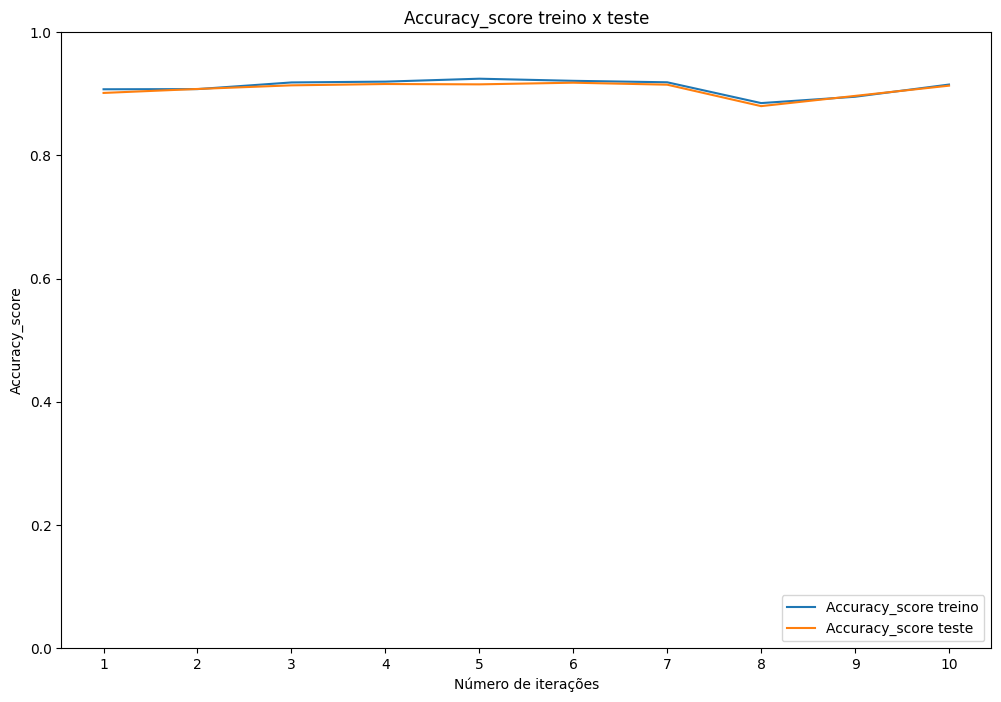

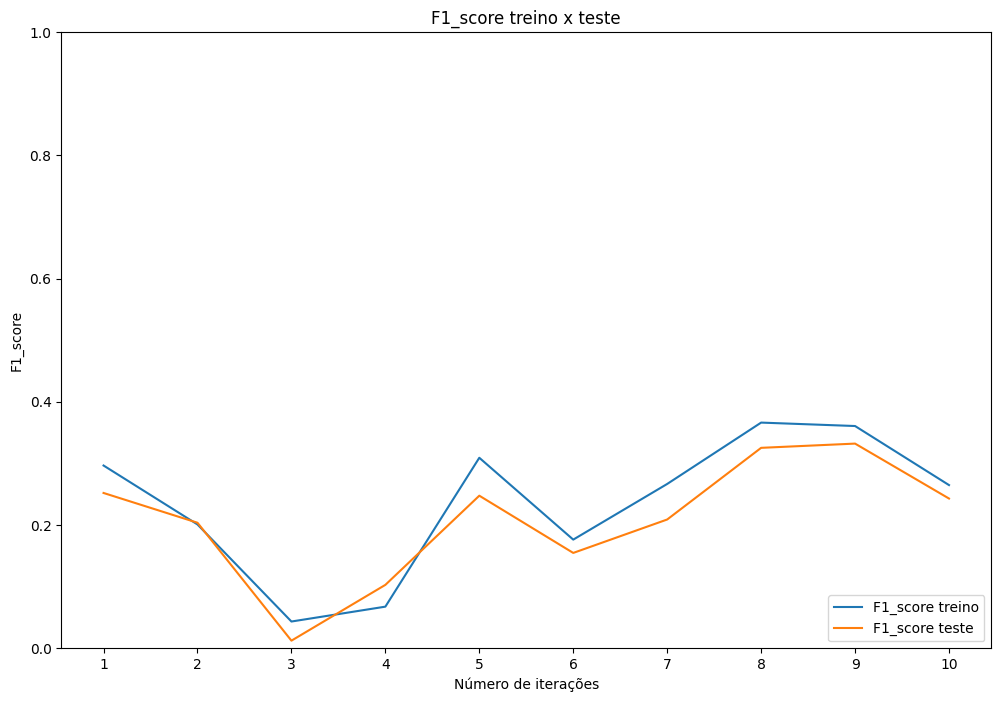

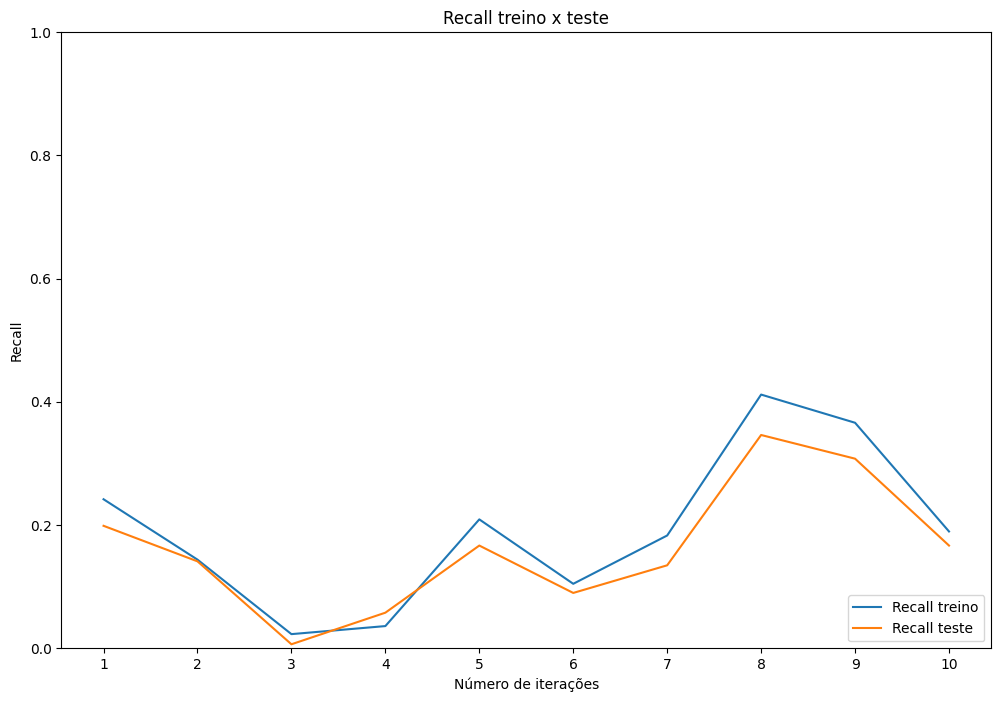

In [ ]:
#Plotando resultados
import matplotlib.pyplot as plt

acc_treino = []
acc_teste = []
f1_treino = []
f1_teste = []
recall_treino = []
recall_teste = []

def plota_resultados(treino, teste, metrica):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes()
    ax.plot(np.arange(1, len(treino)+1), treino, label=f'{metrica} treino')
    ax.plot(np.arange(1, len(treino)+1), teste, label=f'{metrica} teste')
    ax.legend(loc='lower right')
    plt.xticks(np.arange(1, len(treino)+1))
    plt.ylim((0.0, 1.0))
    plt.ylabel(metrica)
    plt.xlabel('Número de iterações')
    plt.title(f'{metrica} treino x teste')
    plt.savefig(f'{metrica}.png')


for result in results_setfit:
    acc_treino.append(result[0])
    acc_teste.append(result[1])
    f1_treino.append(result[2])
    f1_teste.append(result[3])
    recall_treino.append(result[4])
    recall_teste.append(result[5])

plota_resultados(acc_treino, acc_teste, 'Accuracy_score')
plota_resultados(f1_treino, f1_teste, 'F1_score')
plota_resultados(recall_treino, recall_teste, 'Recall')